# Predicting Customer Churn
--- 

The project aims to build a predictive model for Beta Bank to anticipate customer churn. By analyzing past behavior and contract terminations, the goal is to predict whether a customer is likely to leave the bank. The dataset includes features like credit score, geography, age, and balance.

Key steps:

1. Data Preparation: Download and prepare the dataset by handling missing values and encoding categorical variables.

2. Class Imbalance Examination: Assess the balance of classes to understand the distribution of the target variable ('Exited').

3. Initial Model Training: Train a baseline model without considering class imbalance to establish a performance baseline.

4. Improving Model Quality: Implement strategies to address class imbalance, such as oversampling or undersampling, and train different models to find the best performer.

5. Final Testing: Evaluate the model's performance using the test set, focusing on metrics like F1 score and AUC-ROC to assess predictive accuracy.

Through these steps, the project aims to develop a robust model that helps Beta Bank identify customers at risk of leaving, enabling proactive retention efforts.

In [115]:
# Install Necessary Packages 

# Data Prep Packages 
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Model Assessment Package 
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Visualization package 
import matplotlib.pyplot as plt

### Data Preparation 
---

In [116]:
try:
    # Attempt to read the data
    data = pd.read_csv('datasets/Churn.csv')
    # If successful, print Confirmation
    print("The data has been read in as data.")
except Exception as e:
    # If an error occurs, print an error message
    print("Error reading data:", e)

The data has been read in as data.


In [117]:
# Check for null values, duplicates, and inappropriate data types 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [118]:
data.duplicated().sum()

0

In [119]:
data['CustomerId'].duplicated().sum()

0

In [120]:
data.sample(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7397,7398,15744044,Fiorentini,572,Germany,Male,47,4.0,99353.42,1,1,0,196549.85,1
1590,1591,15651802,Day,632,Spain,Female,39,5.0,97854.37,2,1,0,93536.38,0
5004,5005,15625092,Colombo,502,Germany,Female,57,3.0,101465.31,1,1,0,43568.31,1


##### Correcting  Data Issues
- Approximately 9% of rows contain a null value in the tenure column. This will be replaced with the median tenure for each age group. 

In [121]:
# Replace null values in tenure column with median for age
grouped_avg = data.groupby('Age')['Tenure'].transform('median')
data['Tenure'] = data['Tenure'].fillna(grouped_avg)

# Check Work 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


##### Exploring the Data

In [122]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.995800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.762118,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


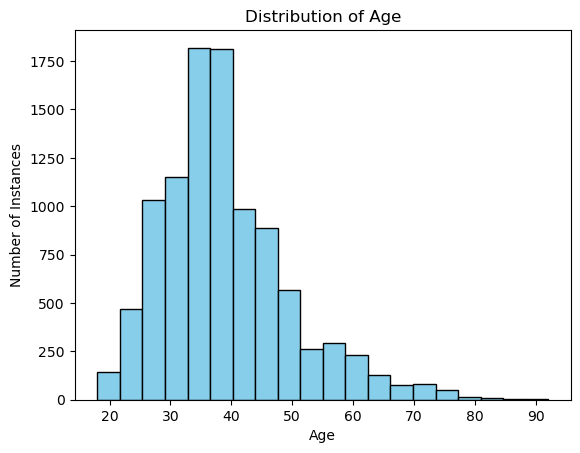

In [123]:
# Create a histogram of the 'Age' column
plt.hist(data['Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Number of Instances')
plt.title('Distribution of Age')

# Show the plot
plt.show()

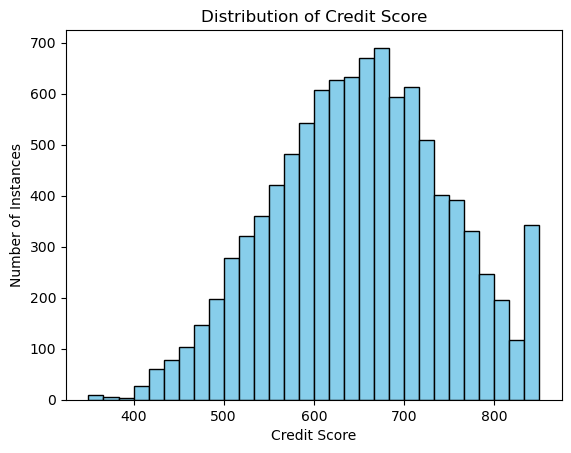

In [124]:
# Create a histogram of the 'CreditScore' column
plt.hist(data['CreditScore'], bins=30, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Credit Score')
plt.ylabel('Number of Instances')
plt.title('Distribution of Credit Score')

# Show the plot
plt.show()

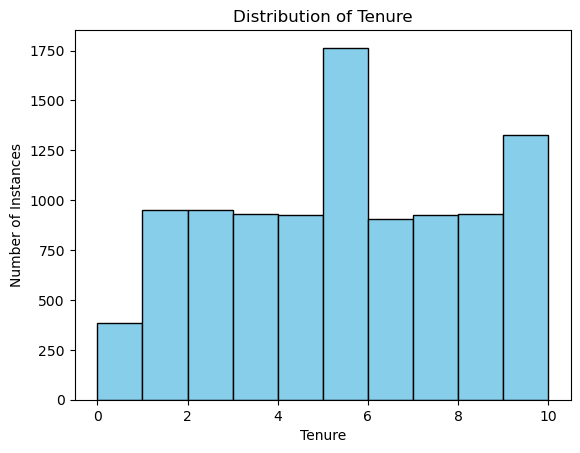

In [125]:
# Create a histogram of the 'Tenure' column
plt.hist(data['Tenure'], bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Tenure')
plt.ylabel('Number of Instances')
plt.title('Distribution of Tenure')

# Show the plot
plt.show()

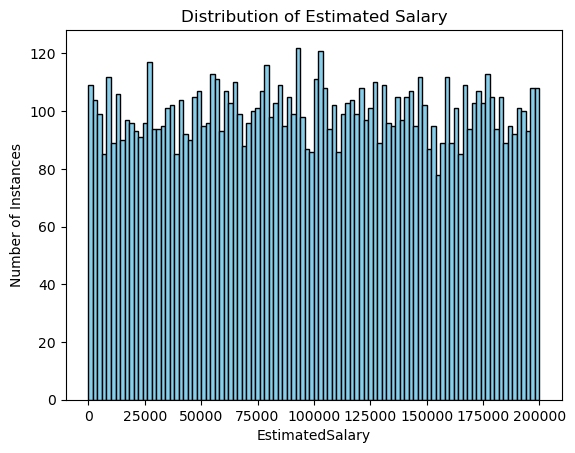

In [126]:
# Create a histogram of the 'EstimatedSalary' column
plt.hist(data['EstimatedSalary'], bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('EstimatedSalary')
plt.ylabel('Number of Instances')
plt.title('Distribution of Estimated Salary')

# Show the plot
plt.show()

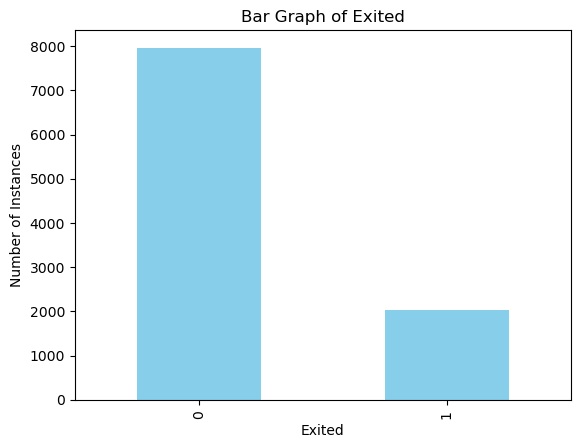

In [127]:
# Count the occurrences of each unique value in the 'Exited' column
exit_counts = data['Exited'].value_counts()

# Plotting the bar graph
exit_counts.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.xlabel('Exited')
plt.ylabel('Number of Instances')
plt.title('Bar Graph of Exited')

# Show the plot
plt.show()

##### Prepare the data to be used in models using one-hot encoding & Split into sets

In [128]:
df = pd.get_dummies(data, drop_first=True)

# Split the data into target and features
target = df['Exited']
features = df.drop('Exited', axis=1)

# Split off the training set
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.40, random_state=12345, stratify=target)

# Split temp set into validation and testing sets
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.50, random_state=12345, stratify=target_temp)

print('features_train size: ', features_train.shape)
print('target_train size: ', target_train.shape)

print('features_valid size: ', features_valid.shape)
print('target_valid size: ', target_valid.shape)

print('features_valid size: ', features_valid.shape)
print('target_valid size: ', target_valid.shape)

features_train size:  (6000, 2944)
target_train size:  (6000,)
features_valid size:  (2000, 2944)
target_valid size:  (2000,)
features_valid size:  (2000, 2944)
target_valid size:  (2000,)


##### Scale Data 

In [129]:
# Create a scaler instance
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
features_train= scaler.fit_transform(features_train)

# Transform the validation and testing data using the same scaler
features_valid = scaler.transform(features_valid)
features_test= scaler.transform(features_test)

**Data Prep Conclusions and Observations**
- It can be observed that age and credit score are normally distributed while tenure and estimated salary do not have a normal distribution.
- It can be observed that the target value of 'Exited' is imbalanced. 

### Class Imbalance Examination
---
In this section, the balance of classes will be accessed to understand the distribution of the target variable ('Exited'). First, a Class Imbalance Ratio will be calculated for the target variable in the training set. This ratio will provide insight into any potential class imbalances within the dataset, indicating whether certain classes are significantly more prevalent than others. Subsequently, the analysis will proceed to train and assess the model without taking into account the identified class imbalance. By doing so, the aim is to understand the impact of class distribution on model performance and explore potential challenges or biases that may arise when disregarding class imbalances during model training and evaluation.

#### Calculate class Imbalance Ratio

In [130]:
# Count the occurrences of each class in the target variable in the training set 
class_counts = target_train.value_counts()

# Calculate the ratio by dividing the count of the majority class by the count of the minority class
imbalance_ratio = class_counts.max() / class_counts.min()

print("Class Imbalance Ratio for the trainng set:", imbalance_ratio)

Class Imbalance Ratio for the trainng set: 3.909983633387889


In [131]:
class_counts

Exited
0    4778
1    1222
Name: count, dtype: int64

#### Train and Access Models with the Class Imbalance

##### Decision Tree with Imbalance

In [132]:
# Set up and train model 
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
# Predict values 
predicted_valid = model.predict(features_valid)

# Calculate f1 score 
print("The f1 score for the Decision tree model with class imbalance: ",f1_score(target_valid, predicted_valid))
print("The AUC ROC score for the Decision tree model with class imbalance: ", roc_auc_score(target_valid, predicted_valid))

The f1 score for the Decision tree model with class imbalance:  0.5537294563843236
The AUC ROC score for the Decision tree model with class imbalance:  0.7168748152527342


##### Random Forest with inbalance 

In [133]:
# Set up and train model 
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
# Predict values 
predicted_valid = model.predict(features_valid)

# Calculate f1 score 
print("The f1 score for the Random Forest model with class imbalance: ",f1_score(target_valid, predicted_valid))
print("The AUC ROC score for the Random Forest model with class imbalance: ", roc_auc_score(target_valid, predicted_valid))

The f1 score for the Random Forest model with class imbalance:  0.5351170568561874
The AUC ROC score for the Random Forest model with class imbalance:  0.6866563208197851


##### Logistic Regression with inbalance 

In [134]:
# Set up and train model 
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

# Calculate f1 score 
print("The f1 score for the Logistic Regression model with class imbalance: ",f1_score(target_valid, predicted_valid))
print("The AUC ROC score for the Logistic Regression model with class imbalance: ", roc_auc_score(target_valid, predicted_valid))

The f1 score for the Logistic Regression model with class imbalance:  0.27070063694267515
The AUC ROC score for the Logistic Regression model with class imbalance:  0.5617671691792294


#### Results 
- A class imbalance ratio of 4.016722408026756 for the training set indicates that there is a significant class imbalance in the dataset. Specifically, it means that one class (the minority class, 1 (Exited = true)) is roughly four times less frequent than the other class (the majority class, 0 (Exited = false)) in the training data. 
- The F1 score of 0.5351170568561874 for the Decision Tree model with class imbalance indicates the harmonic mean of precision and recall achieved by the model. It suggests that the model's performance in correctly identifying instances of both classes, taking into account both false positives and false negatives, is somewhat low performing.
- The F1 score of 0.27070063694267515 for the Logistic Regression model with class imbalance indicates the harmonic mean of precision and recall achieved by the model. It suggests that the model's performance in correctly identifying instances of both classes, taking into account both false positives and false negatives, is low performing.

### Improve Model Quality 
---
Class weight adjustment and upsampling 

#### Class Weight Adjustment

Train and assess the Decision Tree, Random Forest, and Logistic Regression models with the class_weight='balanced' argument. 

##### Decision tree with balanced classes and various depths

In [135]:
# Initialize variables to hold info on the model with the highest accuracy
best_model = None
f1_best = 0
best_depth = 0
best_ar = 0 

# Loop through various max depths to establish which produces the model with the highest accuracy 
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth= depth)
    # train the model
    model.fit(features_train, target_train)
    # get the model's predictions
    predictions_valid = model.predict(features_valid) 
    # calculate the f1 and Auc Roc
    result = f1_score(target_valid, predictions_valid)
    ar = roc_auc_score(target_valid, predictions_valid)
    # Compare new accuracy to previous highest accuracy
    if result > f1_best:  
        best_model = model
        f1_best = result
        best_depth = depth
        best_ar = ar
        
        
print("F1 Score of the best Decision Tree model on the validation set: ", f1_best)
print("The Decision Tree model with the highest F1 had a max depth of: ", best_depth)
print("The Decision Tree model with the highest F1 had a AUC ROC of: ", best_ar)

F1 Score of the best Decision Tree model on the validation set:  0.5834333733493396
The Decision Tree model with the highest F1 had a max depth of:  18
The Decision Tree model with the highest F1 had a AUC ROC of:  0.7406333136269584


##### Random Forest with balanced classes and various estimators

In [136]:
# Initialize variables to hold info on the model with the highest accuracy
best_model = None
f1_best = 0
best_depth = 0
best_estimators = 0
best_ar = 0 

# List of estimators to try
estimators_to_try = [50, 100, 200, 300]

for est in estimators_to_try:
    model = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators=est, max_depth=None)

    # Train the model
    model.fit(features_train, target_train)

    # Get the model's predictions
    predictions_valid = model.predict(features_valid)

     # Calculate the accuracy
    result = f1_score(target_valid, predictions_valid)
    ar = roc_auc_score(target_valid, predictions_valid)

    # Compare new accuracy to previous highest accuracy
    if result > f1_best:
        best_model = model
        f1_best = result
        best_estimators = est
        best_ar = ar
            
print("F1 Score of the best Random Forest model on the validation set: ", f1_best)
print("The Random Forest model with the highest F1 score had this many estimators: ", best_estimators)
print("The Random Forest model with the highest F1 score had an Auc Roc Score of: ", best_ar)

F1 Score of the best Random Forest model on the validation set:  0.48239436619718307
The Random Forest model with the highest F1 score had this many estimators:  100
The Random Forest model with the highest F1 score had an Auc Roc Score of:  0.6606685387722928


##### Logistic Regression with balanced classes

In [137]:
model = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Logistic Regression with balanced classes F1 Score:', f1_score(target_valid, predicted_valid))
print('Logistic Regression with balanced classes AUC ROC Score:', roc_auc_score(target_valid, predicted_valid))

Logistic Regression with balanced classes F1 Score: 0.38436482084690554
Logistic Regression with balanced classes AUC ROC Score: 0.6113841265149276


#### Upsampling
Increase the number of instances of the minority case in the traing set. 

In [138]:
def upsample(features, target, repeat):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.DataFrame(target[target == 0])
    target_ones = pd.DataFrame(target[target == 1])

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )
    target_upsampled = np.ravel(target_upsampled)

    return features_upsampled, target_upsampled

# Upsample the minority class in target_train (class 1)
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

# Check the shape of the upsampled data
print("Upsampled features shape:", features_upsampled.shape)
print("Upsampled target shape:", target_upsampled.shape)



Upsampled features shape: (9666, 2944)
Upsampled target shape: (9666,)


##### Decision Tree with Upsampled Data

In [139]:
# Initialize variables to hold info on the model with the highest accuracy
best_model = None
f1_best = 0
best_depth = 0
best_ar = 0

# Loop through various max depths to establish which produces the model with the highest accuracy 
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth= depth)
    # train the model
    model.fit(features_upsampled, target_upsampled)
    # get the model's predictions
    predictions_valid = model.predict(features_valid) 
    # calculate the f1 and Auc Roc
    result = f1_score(target_valid, predictions_valid)
    ar = roc_auc_score(target_valid, predictions_valid)
    # Compare new accuracy to previous highest accuracy
    if result > f1_best:  
        best_model = model
        f1_best = result
        best_depth = depth
        best_ar = ar
        
        
print("F1 Score of the best Decision Tree model on the validation set: ", f1_best)
print("The Decision Tree model with the highest f1 had a max depth of: ", best_depth)
print("The Decision Tree model with the highest f1 had an AUC ROC of: ", best_ar)

F1 Score of the best Decision Tree model on the validation set:  0.5839080459770115
The Decision Tree model with the highest f1 had a max depth of:  17
The Decision Tree model with the highest f1 had an AUC ROC of:  0.7459478766380924


##### Random Forest with upsampled data and various depths and estimators

In [140]:
# Initialize variables to hold info on the model with the highest accuracy
best_model = None
f1_best = 0
best_estimators = 0
best_ar = 0 

# List of estimators to try
estimators_to_try = [50, 100, 200, 300] 

# Loop through various values of max_depth and n_estimators
for est in estimators_to_try:
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=None)

    # Train the model
    model.fit(features_upsampled, target_upsampled)

    # Get the model's predictions
    predictions_valid = model.predict(features_valid)

    # Calculate the accuracy
    result = f1_score(target_valid, predictions_valid)
    ar = roc_auc_score(target_valid, predictions_valid)

    # Compare new accuracy to previous highest accuracy
    if result > f1_best:
        best_model = model
        f1_best = result
        best_estimators = est
        best_ar = ar 
            
print("F1 Score of the best Random Forest model on the validation set: ", f1_best)
print("The Random Forest model with the highest F1 score had this many estimators: ", best_estimators)
print("The Random Forest model with the highest F1 score had an AUC ROC of ", best_ar)

F1 Score of the best Random Forest model on the validation set:  0.583941605839416
The Random Forest model with the highest F1 score had this many estimators:  300
The Random Forest model with the highest F1 score had an AUC ROC of  0.7209146221302591


##### Logistic Regression with Upsampled Data

In [141]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print('Logistic Regression with upsampled data F1 Score:', f1_score(target_valid, predicted_valid))
print('Logistic Regression with upsampled data AUC ROC Score:', roc_auc_score(target_valid, predicted_valid))

Logistic Regression with upsampled data F1 Score: 0.3778501628664495
Logistic Regression with upsampled data AUC ROC Score: 0.6067654448714159


#### Downsampling 

In [142]:
def downsample(features, target, fraction):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.DataFrame(target[target == 0])
    target_ones = pd.DataFrame(target[target == 1])

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )
    target_downsampled = np.ravel(target_downsampled)

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.25
)

##### Decision Tree with Downsampled Data

In [143]:
# Initialize variables to hold info on the model with the highest accuracy
best_model = None
f1_best = 0
best_depth = 0
best_ar = 0

# Loop through various max depths to establish which produces the model with the highest accuracy 
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth= depth)
    # train the model
    model.fit(features_downsampled, target_downsampled)
    # get the model's predictions
    predictions_valid = model.predict(features_valid) 
    # calculate the f1 and Auc Roc
    result = f1_score(target_valid, predictions_valid)
    ar = roc_auc_score(target_valid, predictions_valid)
    # Compare new accuracy to previous highest accuracy
    if result > f1_best:  
        best_model = model
        f1_best = result
        best_depth = depth
        best_ar = ar
        
        
print("F1 Score of the best Decision Tree model on the validation set: ", f1_best)
print("The Decision Tree model with the highest f1 had a max depth of: ", best_depth)
print("The Decision Tree model with the highest f1 had an AUC ROC of: ", best_ar)

F1 Score of the best Decision Tree model on the validation set:  0.5940409683426443
The Decision Tree model with the highest f1 had a max depth of:  7
The Decision Tree model with the highest f1 had an AUC ROC of:  0.7819489604887181


##### Random Forest with downsampled data 

In [144]:
# Initialize variables to hold info on the model with the highest accuracy
best_model = None
f1_best = 0
best_estimators = 0
best_ar = 0 

# List of estimators to try
estimators_to_try = [50, 100, 200, 300]

# Loop through various values of max_depth and n_estimators
for est in estimators_to_try:
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=None)

    # Train the model
    model.fit(features_downsampled, target_downsampled)

    # Get the model's predictions
    predictions_valid = model.predict(features_valid)

    # Calculate the accuracy
    result = f1_score(target_valid, predictions_valid)
    ar = roc_auc_score(target_valid, predictions_valid)

    # Compare new accuracy to previous highest accuracy
    if result > f1_best:
        best_model = model
        f1_best = result
        best_estimators = est
        best_ar = ar 
            
print("F1 Score of the best Random Forest model on the validation set: ", f1_best)
print("The Random Forest model with the highest F1 score had this many estimators: ", best_estimators)
print("The Random Forest model with the highest F1 score had an AUC ROC of ", best_ar)

F1 Score of the best Random Forest model on the validation set:  0.5990697674418605
The Random Forest model with the highest F1 score had this many estimators:  300
The Random Forest model with the highest F1 score had an AUC ROC of  0.786253571780471


##### Logistic Regression WIth Downsampled Data

In [145]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print('Logistic Regression with downsampled data F1 Score:', f1_score(target_valid, predicted_valid))
print('Logistic Regression with downsampled data AUC ROC Score:', roc_auc_score(target_valid, predicted_valid))

Logistic Regression with downsampled data F1 Score: 0.39536679536679536
Logistic Regression with downsampled data AUC ROC Score: 0.6155470982362794


**Results:**

It appears the the highest F1 score (0.5990697674418605) yields from the Random Forest model with 300 estimators and downsampled data.

#### Further Optimization with the Random Forest Model
---
In a final effort to optimize the F1 score, a threshold adjustment will also be tried in conjunction with the Random Forest model with 300 estimators and downsampled data.

In [146]:
# Initialize RandomForestClassifier
model = RandomForestClassifier(random_state=12345, n_estimators=300, max_depth=None)

# Train the model
model.fit(features_downsampled, target_downsampled)

# Predict probabilities for the positive class (class 1)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

# Loop through a range of thresholds
for threshold in np.arange( 0.5, 0.8, 0.02):
    # Convert predicted probabilities into binary predictions using the threshold
    predicted_valid = probabilities_one_valid > threshold
    
    # Calculate precision and recall scores
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    ar = roc_auc_score(target_valid, predicted_valid)
    
    # Print the threshold, precision, and recall for each iteration
    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}'.format(threshold, precision, recall))
    print(f1)
    print(ar)


Threshold = 0.50 | Precision = 0.483, Recall = 0.789
0.5990697674418605
0.786253571780471
Threshold = 0.52 | Precision = 0.507, Recall = 0.757
0.6076696165191741
0.7844553650605971
Threshold = 0.54 | Precision = 0.534, Recall = 0.728
0.6161825726141079
0.7826263671297665
Threshold = 0.56 | Precision = 0.551, Recall = 0.694
0.6138828633405641
0.7742634742339147
Threshold = 0.58 | Precision = 0.562, Recall = 0.662
0.6081081081081082
0.7649275790718296
Threshold = 0.60 | Precision = 0.580, Recall = 0.627
0.6030624263839812
0.7556224751207016
Threshold = 0.62 | Precision = 0.604, Recall = 0.598
0.6009852216748768
0.7487683515617303
Threshold = 0.64 | Precision = 0.631, Recall = 0.566
0.5968992248062016
0.7406887378066804
Threshold = 0.66 | Precision = 0.667, Recall = 0.544
0.5991902834008096
0.7371970144841856
Threshold = 0.68 | Precision = 0.691, Recall = 0.510
0.5867418899858955
0.7256934180707458
Threshold = 0.70 | Precision = 0.714, Recall = 0.466
0.5637982195845698
0.7089737905212335


**Result:**

From the above test it can be observed that the optimal threshold is .54, resulting in an F1 score of 0.6161825726141079 and an AUC ROC of 0.7826263671297665 on the validation set. 

### Final Testing 
---

In [147]:
# Initialize RandomForestClassifier
model = RandomForestClassifier(random_state=12345, n_estimators=300, max_depth=None)

# Train the model
model.fit(features_downsampled, target_downsampled)

# Predict probabilities for the positive class (class 1)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

# Manually adjust the threshold to 0.54
threshold = 0.54
predicted_test = probabilities_one_test > threshold

# Calculate precision and recall scores
precision = precision_score(target_test, predicted_test)
recall = recall_score(target_test, predicted_test)
f1 = f1_score(target_test, predicted_test)
ar = roc_auc_score(target_test, predicted_test)
accuracy = accuracy_score(target_test, predicted_test)

print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}'.format(threshold, precision, recall))
print('F1 Score: ', f1)
print('AUC ROC Score: ', ar)
print('Accuracy Score: ', accuracy)


Threshold = 0.54 | Precision = 0.515, Recall = 0.693
F1 Score:  0.5905759162303665
AUC ROC Score:  0.7629470765063986
Accuracy Score:  0.8045


**Conclusion:** 

In our efforts to predict customer churn for Beta Bank, we undertook a comprehensive analysis starting from data preparation to model evaluation. Here, we summarize our findings and the steps taken to achieve the best-performing model.

Initially, we observed that the dataset contained imbalanced classes, with the minority class (customers who exited) being significantly less prevalent than the majority class. To address this imbalance, we experimented with various strategies including using the 'balanced' hyperparameter, upsampling, and downsampling techniques during model training.

After training multiple models including Decision Trees, Random Forests, and Logistic Regression with different hyperparameters and data sampling techniques, we found that the Random Forest model with 300 estimators and downsampled data consistently outperformed others, achieving the highest F1 score of approximately 0.599.

Further optimization was performed by adjusting the threshold of the Random Forest model, resulting in a higher F1 score of 0.616 and an AUC ROC of 0.783 on the validation set. This adjustment proved to be effective in improving the model's performance in identifying instances of both classes, balancing precision and recall.

In conclusion, with the Random Forest model utilizing 300 estimators, downsampled training data, and a threshold adjusted to 0.54, we achieved an F1 score of approximately 0.59 on the test data. This indicates that our model is capable of effectively identifying customers at risk of churn, providing Beta Bank with valuable insights for proactive retention efforts.